In [1]:
#imports
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import itertools
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.model_selection import KFold, StratifiedKFold, cross_validate, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression 

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn import tree

%matplotlib inline

# Column names from the word document "Network Anamoly Detection" for the dataset
column_names = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land",
"wrong_fragment","urgent","hot","num_failed_logins","logged_in",
"num_compromised","root_shell","su_attempted","num_root","num_file_creations",
"num_shells","num_access_files","num_outbound_cmds","is_host_login",
"is_guest_login","count","srv_count","serror_rate", "srv_serror_rate",
"rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate", "srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
"dst_host_diff_srv_rate","dst_host_same_src_port_rate",
"dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
"dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

dataset = pd.read_csv("../Data/Train.txt", names=column_names)
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,last_flag
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal,20
1,0,udp,other,SF,146,0,0,0,0,0,...,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal,15
2,0,tcp,private,S0,0,0,0,0,0,0,...,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune,19
3,0,tcp,http,SF,232,8153,0,0,0,0,...,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal,21
4,0,tcp,http,SF,199,420,0,0,0,0,...,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal,21


In [2]:
# Removing rows with no values in them
print("shape pre-dropna:", dataset.shape)
dataset.dropna(inplace=True)
print("shape post-dropna:", dataset.shape)

shape pre-dropna: (125973, 43)
shape post-dropna: (125973, 43)


In [3]:
# Giving the categories in the nominal features a separate column each with binarY/boolean values
temp = pd.get_dummies(dataset[['protocol_type', 'service', 'flag']]).astype('int')
# Replaces three features with eighty-four features boolean
print("Features created from 'protocol_type', 'service', and 'flag':", temp.shape)

# Getting the attack classes from the dataset
attack_classes = dataset.attack
attack_classes_dummy = pd.get_dummies(dataset['attack']).astype('int')

# Normal traffic is classified as 0, while malicious traffic is classed as 1.
def mapping(val):
    if val == "normal":
        return 0
    else:
        return 1
    
attack_classes_int = attack_classes.apply(mapping)

# Dropping the independent variable 'attack' and the columns 'protocol_type', 'service', and 'flag' 
temporary_dataset = dataset.drop(['attack', 'protocol_type', 'service', 'flag'], axis=1).astype('float64')
new_dataset = pd.concat([temporary_dataset, temp], axis=1)

print("New dataset's shape:", new_dataset.shape)
new_dataset.head()

Features created from 'protocol_type', 'service', and 'flag': (125973, 84)
New dataset's shape: (125973, 123)


,duration,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,num_failed_logins,logged_in,num_compromised,...,flag_REJ,flag_RSTO,flag_RSTOS0,flag_RSTR,flag_S0,flag_S1,flag_S2,flag_S3,flag_SF,flag_SH
0,0.0,491.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1,0.0,146.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,1,0,0,0,0,0
3,0.0,232.0,8153.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0
4,0.0,199.0,420.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,1,0


### Eliminating highly correlated features.

num_compromised and num_root are highly correlated (0.9988334525784719)
num_root and num_compromised are highly correlated (0.9988334525784719)
serror_rate and srv_serror_rate are highly correlated (0.9932892425370415)
serror_rate and dst_host_serror_rate are highly correlated (0.9793730829843228)
serror_rate and dst_host_srv_serror_rate are highly correlated (0.9811389586179857)
serror_rate and flag_S0 are highly correlated (0.9791740914923958)
srv_serror_rate and serror_rate are highly correlated (0.9932892425370415)
srv_serror_rate and dst_host_serror_rate are highly correlated (0.9775960119654394)
srv_serror_rate and dst_host_srv_serror_rate are highly correlated (0.9862517164930875)
srv_serror_rate and flag_S0 are highly correlated (0.9826599622600537)
rerror_rate and srv_rerror_rate are highly correlated (0.9890076529820739)
rerror_rate and dst_host_rerror_rate are highly correlated (0.9267485035759243)
rerror_rate and dst_host_srv_rerror_rate are highly correlated (0.96444866550

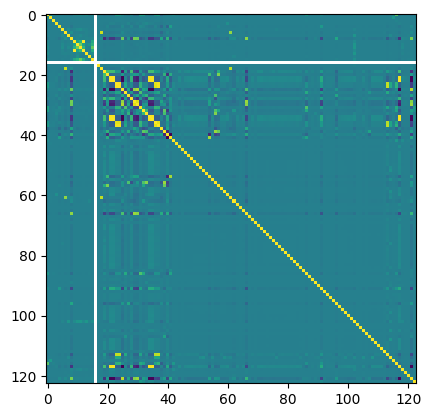

[[1.0, 0.07073682819085414, 0.03487779833437003, -0.0015532805525947443, -0.009865808515815139, 0.003829897181915918, 0.000705120566211187, 0.009528249936349882, -0.06421767647301116, 0.042679474817442095, 0.052790950792928525, 0.08718341292134439, 0.045519157361409816, 0.09911569750163096, -0.0015934673468352128, 0.07041992093460996, nan, -0.00025761943672739616, 0.0004402248819930365, -0.07904231889655419, -0.03947023790265667, -0.06987295957015192, -0.06951028293813129, 0.2006819844142431, 0.19996108167067075, 0.07468058598343401, -0.01373757895926031, -0.04015809532609311, 0.05057003428877992, -0.109775561199984, -0.11600495557790014, 0.2541951745852428, 0.2287373765622746, -0.026669376728929953, -0.06494796244229974, -0.06436051447487312, 0.1738152898998144, 0.19902360421159065, -0.15631061303783145, -0.029263345542364316, -0.004642982519098148, 0.027974374377361635, 0.09319418730832142, 0.0037412564778459014, -0.007744632866980154, -0.0004392939757158932, -0.008205440388428653, -

In [4]:
result = []
for columnx in new_dataset.columns:
    resulting_row = []
    for columny in new_dataset.columns:
        correlation = new_dataset[columnx].corr(new_dataset[columny])
        if (columnx != columny) and ((correlation > 0.9) or (correlation < -0.9)):
            print(f"{columnx} and {columny} are highly correlated ({correlation})")
        resulting_row.append(correlation)
    result.append(resulting_row)

plt.imshow(result)
plt.show()

print(result)

From the results above we can see that the following features are highly correlated:
* num_compromised and num_root
* serror_rate, srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, and flag_S0
* rerror_rate, srv_rerror_rate, dst_host_rerror_rate, dst_host_srv_rerror_rate

Therefore the remaining features will be (as the rest will be dropped):
* num_root
* serror_rate
* rerror_rate

In [5]:
# Dropping the features:
# num_compromised,
# srv_serror_rate, dst_host_serror_rate, dst_host_srv_serror_rate, flag_S0,
# srv_rerror_rate, dst_host_rerror_rate, and dst_host_srv_rerror_rate 
print("pre:", new_dataset.shape)
features_droppping = ['num_compromised',
                      'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'flag_S0',
                      'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']
new_dataset = new_dataset.drop(features_droppping, axis=1).astype('float64')
print("post:", new_dataset.shape)

pre: (125973, 123)
post: (125973, 115)


### Feature importance

In [6]:
dataset_train, dataset_test, value_train, value_test = train_test_split(new_dataset, attack_classes_int)

forest = RandomForestClassifier(random_state=0)
forest.fit(dataset_train, value_train)

RandomForestClassifier(random_state=0)

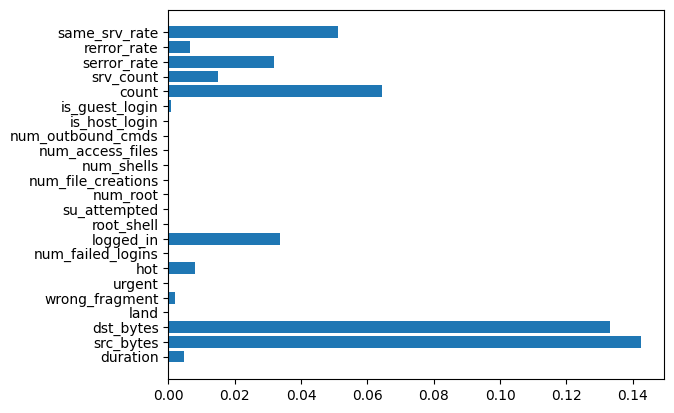

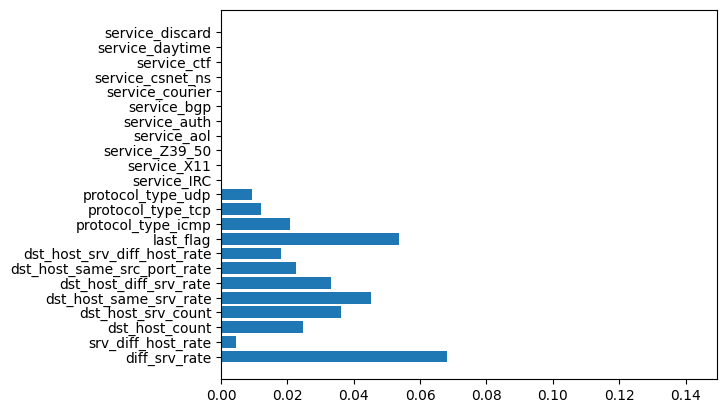

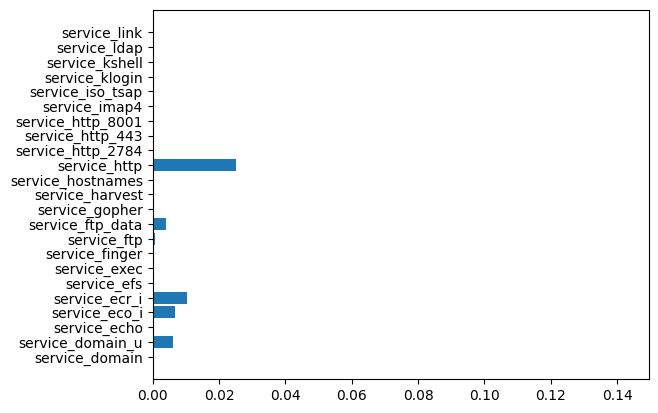

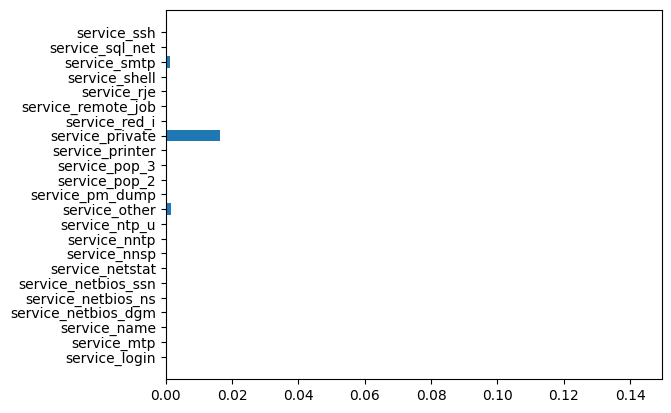

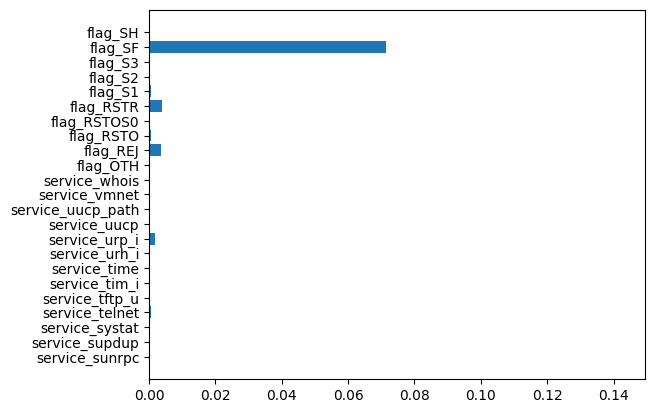

In [7]:
highest_value = max(forest.feature_importances_)
split_columns = np.array_split(new_dataset.columns, 5)
split_importances = np.array_split(forest.feature_importances_, 5)
for index in range(len(split_columns)):
    plt.barh(split_columns[index], split_importances[index])
    plt.xlim(0, highest_value + (highest_value*0.05))
    plt.show()


In [8]:
forest_importances = pd.Series(forest.feature_importances_, index=([x for x in dataset_train.columns]))
print("Number of important features:", len(forest_importances[forest_importances > 0.01]))
forest_importances.nlargest(len(forest_importances[forest_importances > 0.01]))
# protocol_type_tcp swapped out with service_eco_i

Number of important features: 21


src_bytes                      0.142400
dst_bytes                      0.132999
flag_SF                        0.071382
diff_srv_rate                  0.068224
count                          0.064326
last_flag                      0.053687
same_srv_rate                  0.051042
dst_host_same_srv_rate         0.045146
dst_host_srv_count             0.036192
logged_in                      0.033728
dst_host_diff_srv_rate         0.033064
serror_rate                    0.031984
service_http                   0.025180
dst_host_count                 0.024557
dst_host_same_src_port_rate    0.022489
protocol_type_icmp             0.020744
dst_host_srv_diff_host_rate    0.018138
service_private                0.016464
srv_count                      0.015082
protocol_type_tcp              0.012106
service_ecr_i                  0.010467
dtype: float64

In [9]:
# print(len(forest.estimators_))
# print(forest.estimators_)
# tree.plot_tree(forest.estimators_[0])

Correct predictions: 31484
Incorrect predictions: 10
Total samples: 31494
Accuracy score: 0.9996824792023877


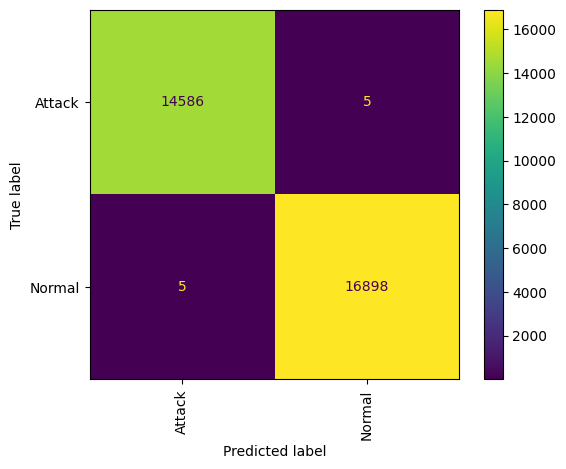

In [10]:
groups = ["Normal", "Attack"]

predicted_attacks = []
actual_attacks = []

for val in value_test:
    actual_attacks.append(groups[val])
for predicted_val in forest.predict(dataset_test):
    predicted_attacks.append(groups[predicted_val])

display = ConfusionMatrixDisplay.from_predictions(actual_attacks, predicted_attacks, xticks_rotation=90)

correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(value_test) - correct_predictions)
print("Total samples:", len(value_test))
print("Accuracy score:", correct_predictions/len(value_test))

# Correct predictions: 31480
# Incorrect predictions: 14
# Total samples: 31494
# Accuracy score: 0.9995554708833428

Making a new random forest model with the features having a variable importance over 0.01

In [11]:
important_features = forest_importances.nlargest(len(forest_importances[forest_importances > 0.01]))
new_forest = RandomForestClassifier(random_state=0)
new_forest.fit(dataset_train[important_features.index], value_train)



RandomForestClassifier(random_state=0)

In [12]:
# print(len(new_forest.estimators_))
# print(new_forest.estimators_)
# tree.plot_tree(new_forest.estimators_[0])

In [13]:
scores = cross_val_score(new_forest, new_dataset, attack_classes_int, scoring="accuracy", cv=10)
print("Mean score:", np.mean(scores))
print("Max score:", np.max(scores))
print("Min score:", np.min(scores))
print("Standard deviation:", np.std(scores))
print("Standard variance:", np.var(scores))

# Mean score: 0.9996745357628234
# Max score: 0.9999206160196872
# Min score: 0.9994443562470233
# Standard deviation: 0.00017190659459422614
# Standard variance: 2.955187726498362e-08

Mean score: 0.9996745357628234
Max score: 0.9999206160196872
Min score: 0.9994443562470233
Standard deviation: 0.00017190659459422614
Standard variance: 2.955187726498362e-08


Correct predictions: 31479
Incorrect predictions: 15
Total samples: 31494
Accuracy score: 0.9995237188035816


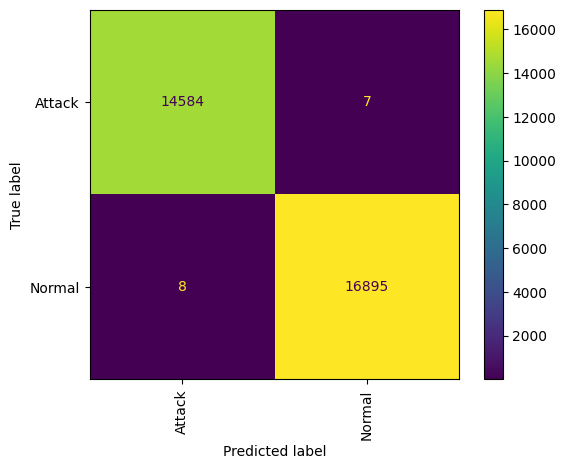

In [14]:
groups = ["Normal", "Attack"]

predicted_attacks = []
actual_attacks = []

for val in value_test:
    actual_attacks.append(groups[val])
for predicted_val in new_forest.predict(dataset_test[important_features.index]):
    predicted_attacks.append(groups[predicted_val])

display = ConfusionMatrixDisplay.from_predictions(actual_attacks, predicted_attacks, xticks_rotation=90)

correct_predictions = 0
for index in range(len(display.confusion_matrix)):
    correct_predictions += display.confusion_matrix[index][index]
print("Correct predictions:", correct_predictions)
print("Incorrect predictions:", len(value_test) - correct_predictions)
print("Total samples:", len(value_test))
print("Accuracy score:", correct_predictions/len(value_test))

# Correct predictions: 31479
# Incorrect predictions: 15
# Total samples: 31494
# Accuracy score: 0.9995237188035816


Interesting observation that even with binary classification with random forest the model is more accurate than logistical regression.

Also reducing features here actually made the model more inacurrate however these inaccuaracies are so low.